# Introduction

This notebook introduces three resources for working with Japanese Kanji:

1. KRAD
2. CHISE
3. Heisig

Through examples, we show how you can apply each resource to break Kanji down into subcomponents.

# KRAD

The [KRAD project](http://www.edrdg.org/krad/kradinf.html) is of the many useful projects of [Electronic Dictionary Research & Development Group](http://www.edrdg.org/edrdg/index.html).
It consists of two mappings: Kanji to radical (krad) and radical to Kanji (radk).
Since we're breaking down Kanji, we're more interested in the former.
Let's download the file and have a peek at it.

In [1]:
# Simplest way to acquire the file is with wget, if you're in a GNU environment.
#
# ! wget ftp://ftp.monash.edu/pub/nihongo/kradfile.gz

In [2]:
import gzip
with gzip.GzipFile('kradfile.gz') as fin:
    krad = fin.read().decode('euc-jp')
    
# The krad file describes the radicals present in each Kanji
print('\n'.join(krad.split('\n')[100:120]))

唖 : ｜ 一 口
娃 : 女 土
阿 : 一 口 亅 阡
哀 : 衣 口 亠
愛 : 心 爪 冖 夂
挨 : 矢 厶 扎 乞
姶 : 一 口 女 个
逢 : ｜ 込 二 夂
葵 : 人 大 二 癶 艾 ノ
茜 : 西 艾
穐 : 禾 亀 乙 勹 田
悪 : ｜ 一 口 心
握 : 至 土 厶 尸 扎
渥 : 至 汁 土 厶 尸
旭 : 日 九
葦 : 口 艾 韋
芦 : 戸 艾 一 尸
鯵 : 魚 大 田 厶 彡 杰
梓 : 十 辛 木 立
圧 : 土 厂


In [3]:
# It's really easy to parse...
def parse_krad():
    for line in krad.split('\n'):
        if line and line[0] == "#":
            continue
        elif ' : ' in line:
            kanji, radicals = line.split(' : ')
            radicals = radicals.split(' ')
            yield kanji, radicals
        
krad_dict = dict(parse_krad())

# So now, we can get the radicals present in any Kanji.  Cool, huh?
krad_dict['鉄']

['ノ', '金', '二', '矢', '大', '乞']

In [4]:
# Problems:
#   1. The order of the radicals appears to be quite random
#   2. No positional information

# CHISE (Character Information Service Environment)

The [CHISE](http://www.chise.org/ids/index.html) project is similar to the krad file we looked at above.
However, instead of decomposing a Kanji into a mere set of radicals, they decompose each Kanji into ideographs (essentially, simpler Kanji) and keep track of the _position_ of each ideograph within the Kanji, as well as the number of times that it appears.  This can be more helpful than krad.

In [5]:
# ! wget "http://git.chise.org/gitweb/?p=chise/ids.git;a=blob_plain;f=IDS-UCS-Basic.txt" -O IDS-UCS-Basic.txt

In [6]:
chise = open('IDS-UCS-Basic.txt', encoding='utf-8').read().rstrip()
print('\n'.join(chise.split('\n')[:20]))

;; -*- coding: utf-8-mcs-er -*-
U+4E00	一	一
U+4E01	丁	丁
U+4E02	丂	丂
U+4E03	七	七
U+4E04	丄	丄
U+4E05	丅	丅
U+4E06	丆	⿱一丿
U+4E07	万	万
U+4E08	丈	丈
U+4E09	三	三
U+4E0A	上	上
U+4E0B	下	下
U+4E0C	丌	丌
U+4E0D	不	不
U+4E0E	与	⿹&CDP-8BBF;一
U+4E0F	丏	丏
U+4E10	丐	丐
U+4E11	丑	丑
U+4E12	丒	⿱刃一


In [7]:
def parse_chise_ideographs(text):
    #
    # Each ideograph is either:
    # 
    #     1) A single character, where a character for the ideograph actually exists
    #     2) An escape code in the form of "&CDP-FFFF;", where FFFF is hex for the code.
    #
    while text:
        if text.startswith('&'):
            end = text.index(';')
            yield text[:end + 1]
            text = text[end + 1:]
        else:
            yield text[0]
            text = text[1:]
    
def parse_chise():
    for line in chise.split('\n')[1:]:
        code_point, kanji, ideographs = line.rstrip().split('\t', 2)
        yield kanji, list(parse_chise_ideographs(ideographs))
        
chise_dict = dict(parse_chise())
chise_dict['鉄']

['⿰', '金', '失']

In [8]:
# Let's look at the available Kanji layouts.
# Recall that the first element in the ideograph list is the layout.
import collections
most_common = collections.Counter(ideo[0] for ideo in chise_dict.values()).most_common(12)
most_common

[('⿰', 14438),
 ('⿱', 4117),
 ('⿸', 694),
 ('⿺', 458),
 ('⿵', 218),
 ('⿳', 156),
 ('⿴', 138),
 ('⿹', 119),
 ('⿲', 51),
 ('⿷', 41),
 ('⿻', 14),
 ('⿶', 10)]

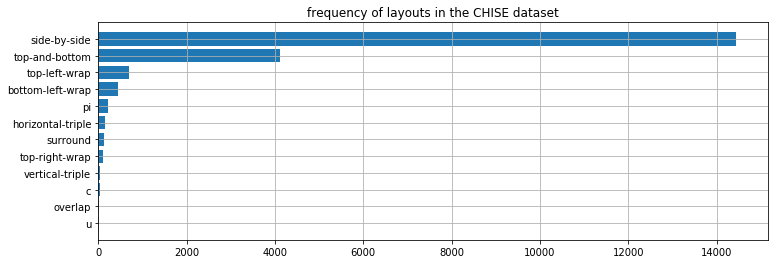

In [9]:
most_common_names = [      # For the purists, the Japanese equivalent is below:
    'side-by-side',        # hen/dzukuri
    'top-and-bottom',      # kanmuri/ashi
    'top-left-wrap',       # tare
    'bottom-left-wrap',    # nyou
    'pi',                  # kamae (enclosing)
    'horizontal-triple',   # ?
    'surround',            # kamae
    'top-right-wrap',      # kamae
    'vertical-triple',     # ?
    'c',                   # kamae
    'overlap',             # ?
    'u',                   # kamae
]
#
# By far the most common layout is left-to-right, followed by top-and-bottom.
# The remaining layouts are far less common, which is possibly why the Japanese
# gave up trying to think up new names for them, and just called them all "kamae". 
#
# Let's plot the above, just because we can
#
%matplotlib inline
import matplotlib.pyplot as plt
most_common_count = [count for (layout, count) in most_common]
y_pos = list(reversed(range(len(most_common_count))))

plt.figure(figsize=(12, 4))
plt.barh(y_pos, most_common_count)
plt.yticks(y_pos, most_common_names)
plt.title('frequency of layouts in the CHISE dataset')
plt.grid();

In [10]:
# Sometimes, you have to perform multiple look-ups to break a Kanji up entirely
print('恕')
print(chise_dict['恕'])
print(chise_dict['如'])

恕
['⿱', '如', '心']
['⿰', '女', '口']


In [11]:
# Let's define a function to do that
def chise_split(kanji):
    try:
        ideographs = chise_dict[kanji]
    except KeyError:
        return [kanji]
    if len(ideographs) == 1:
        return ideographs
    result = []
    for i in ideographs:
        result.extend(chise_split(i))
    return result

chise_split('恕')

['⿱', '⿰', '女', '口', '心']

In [12]:
# TODO: the above represents a traversal of a binary tree

In [13]:
# ... but we digress.  Let's get back to the actual data:
chise_dict['鉄']

['⿰', '金', '失']

The ideographs should be interpreted in [Polish notation](https://en.wikipedia.org/wiki/Polish_notation).
In the example above, the first character outlines the layout of the Kanji: left-to-right.
The following characters correspond to the left and right parts of the Kanji, respectively.
So the above example effectively says that 

# 鉄

can be constructed by squishing the following two characters together:

## 金　失

In [14]:
# You can also flip the mapping to go the other way around
import collections
inv_chise_dict = collections.defaultdict(list)
for kanji, ideographs in chise_dict.items():
    for i in ideographs:
        inv_chise_dict[i].append(kanji)

# Find the Kanji that contains both 金 and 失
set(inv_chise_dict['金']).intersection(set(inv_chise_dict['失']))

# This is particularly helpful when you know _part_ of a Kanji, but don't know the rest of it

{'鉄'}

In [15]:
# The above is so useful!  Let's generalize into a function
def chise_narrow(*parts):
    parts = list(parts)
    first_part = parts.pop()
    candidates = set(inv_chise_dict[first_part])
    while parts:
        candidates = candidates.intersection(set(inv_chise_dict[parts.pop()]))
    return candidates

chise_narrow('心', '口')

{'吢', '吣', '总', '悤'}

# James Heisig: Remembering the Kanji

It is very difficult to work with Kanji without being able to conveniently name them.
For example, conveying the above example verbally in English can be frustrating, because in general, a single Kanji rarely has one, unambiguous meaning, and cannot be expressed by a single English word.
So, how can we refer to these things without becoming fluent in Japanese?

We cheat.  

We assign our own English _keywords_ to the Kanji.
Sometimes they will actually be related to the Kanji somehow, but that won't always be the case.
To reinforce the keywords, we make up our _personal_ story.
The story is your own, so it can be as silly as you like.
What matter is that _you made it, so you can remember it_.

## 鉄 (iron)

## 金 (metal)

## 失 (to lose)

So, one story could be something like:

> Iron is an essential metal for the human body, so it is important not to lose too much of it.

The above is known as the [Heisig Method](https://en.wikipedia.org/wiki/Remembering_the_Kanji_and_Remembering_the_Hanzi).

We can now:

1. Refer to Kanji using an unambiguous English keyword
2. Actually remember the Kanji by connecting it to the keyword via a story

We'll focus on the first point for now.
Let's get the Heisig keywords.
[@ziggr](https://twitter.com/ziggr) has conveniently put them into computer-readable form.

In [16]:
# ! wget http://ziggr.com/heisig/heisig-data.txt.gz

In [17]:
# The Heisig method assigns keywords to Kanji, and groups Kanji into lessons of increasing difficulty.
import io
import csv

def tweak(kanji):
    for key, value in kanji.items():
        if value.isdigit():
            kanji[key] = int(value)
    return dict(kanji)

with gzip.GzipFile('heisig-data.txt.gz') as fin:
    fin.readline()
    reader = csv.DictReader(io.StringIO(fin.read().decode('utf-8')), delimiter=':')
    heisig = [tweak(x) for x in reader]
    
heisig_dict = {k['kanji']: k for k in heisig}
print('鉄', heisig_dict['鉄']['keyword5th-ed'])
print('金', heisig_dict['金']['keyword5th-ed'])
print('失', heisig_dict['失']['keyword5th-ed'])

鉄 iron
金 gold
失 lose
